# Exploring tokens frequency in text data

- This notebook uses CountVectorizer to explore tokens in my article corpus

## Installs and Imports

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

In [1]:
#installing and importing spacy, which I use for tokenizing text
!pip install spacy;
import spacy

     |████████████████████████████████| 185 kB 5.9 MB/s eta 0:00:01
  Attempting uninstall: srsly
    Found existing installation: srsly 2.0.1
    Uninstalling srsly-2.0.1:
      Successfully uninstalled srsly-2.0.1
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
#install spacy english language model
!python -m spacy download en_core_web_sm;

     |████████████████████████████████| 12.0 MB 642 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=8ba3ebeb6cc92b05197ca5c71def52d5d8d714195203902072b3a5301b7b49c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-ltay9jnm/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
#loads spacy's small language model for tokenizer, disabling parameters not needed to speed up performance
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])

In [4]:
#tokenizer helper function, that runs as part of data processing cell
#defines function that takes in string and nlp object
def tokenizer(text, nlp):
    #creates empty list
    token_list = []
    #passes string to spacy doc object
    doc = nlp(text)
    #iterates through doc objecting checking for words that are not stopwords, punctuation or whitespace, lemmatizes word and appends to list
    for token in doc:
        if token.is_stop == False and token.is_punct==False:
            if token.text != ' ':
                token_list.append((token.lemma_).lower())
    str_tokens = ' '.join(token_list)
    return str_tokens

## Reading and shaping data for Modeling

This cell takes in text, metadata, and google trends data, performs transformations, and joins into one master table

In [6]:
#reading in text data from GDELT
print('reading in text data')
df = pd.read_csv('/floyd/home/Capstone/cap_notebooks/data/master_data_set/gdelt_text_tone_complete_oct_22.csv')

display(f'gdelt_df_shape: {df.shape}')
print('\n')

print('DF HEAD')
display(df.head())

print('\n')
print('setting datatime')

#converts datetime
df['date_time'] = pd.to_datetime(df['DATE'])

#sets datetime index
df.set_index('date_time', inplace=True)

print('\n')
print('Filling empty title columns')

#fills missing title with no_title
df['title'].fillna('no_title', inplace = True)

print('\n')
print('tokenizing titles')

#tokenzies title
df['title_tokens'] = df['title'].apply(lambda x: tokenizer(str(x), nlp))

print('\n')
print('joining text and title')

#joins title and text
df['title_text'] = df['title_tokens'] + df['text_tokens']

#display(df.head())
print('Reshaped GDELT DF')
display(f'df: {df.shape}')

print('\n')
print('resampling at 1h')

#resample data into 1 hour increments. Joins articles into one giant string for each hour
test_resample = df.resample('1h')['title_text'].agg(lambda column: "".join(column))
#convert to dataframe
test_resample = pd.DataFrame(test_resample)

print('\n')
print('GDELT Text Resampled by 1 hour')
display(test_resample.head(3))

print('\n')

print('Getting GDELT tonal scores and resampling to 1h by calculating mean')

#grabs scores (I had aspirations of using this data in my model)
scores = df[['avg_tone', 'pos_words', 'neg_words', 'polarity', 'act_ref_density', 'self_group_density', 'word_count']]

#resample scores metadata
scores = scores.resample('1h').mean()

print('\n')
print('GDELT Tonal Dataset')
display(scores.head(3))
print('\n')

#Joining resampled text data with resampled tonal data
print('Joining resampled text data with resampled tonal data')
test_resample = pd.concat([test_resample, scores], axis=1)

#resetting index
test_resample.reset_index(inplace=True)

#display text and tonal resampled data set
print('Text and Tonal resampled GDELT data')
display(test_resample.head(3))
print('\n')

print('Shape of new tonal text GDELT data')
display(f'clean text shape: {test_resample.shape}')

#checking for empty title_text strings. Can't use null here because elements in text are a string, even empty string
print('\n')
print('Checking for empty strings in text feature')
useful_sample_size = (test_resample['title_text'].str.len()>0).sum()

print('\n')
print('Displaying number of empty strings')
display(f'text > 0: {useful_sample_size}')


print('\n')

#Adding padding to text to ensure complete join with Google Trends Target Data
#this is important when I `shift` the Google Trends target data
#Empty strings will eventually be dropped
print('Adding padding to text to ensure complete join with Google Trends Target Data')

#getting column headers
columns = list(test_resample.columns)

#creating list of data for padding
date_list = list(pd.date_range(start='2020-10-07 21:00:00', end='2020-10-11 00:00:00', freq='1h'))

#creating dict of columns with date_list and empty_string
data = {'date_time': date_list, 'title_text': 'empty_string'}

#creatinge padding dataframe
df_holder = pd.DataFrame(data,columns=columns)

#appending padding dataframe to text dataframe
print('\n')
print('appending new padding to test_resample')
test_resample = test_resample.append(df_holder)

print('\n')
print('Reviewing reshaped GDELT text and tonal feature set')
print('\n')

#read in gtrend target data
print('Reading in google trends')

gtrends = pd.read_csv('/floyd/home/Capstone/cap_notebooks/data/google_trends/gtrends_2015-2020_clean.csv')

print('\n')
display(f'gtrend shape: {gtrends.shape}')

print('grouping gtrends data and removing duplicates')
gtrends = gtrends.groupby('date').mean()

display(f'gtrends duplicates removed: {gtrends.shape}')

print('removing extra google trends data')

#returning only Gtrends data that fits in time range of text data
gtrends = gtrends['2015-03-02 00:00:00': '2020-10-10 00:00:00']

#reset index
gtrends.reset_index(inplace=True)

#drop unneeded columns
gtrends.drop(['Unnamed: 0', 'isPartial'], axis=1, inplace=True)

print('setting datetime on gtrends')

#convert date col to datetime
gtrends['date'] = pd.to_datetime(gtrends['date'])

display(f'gtrends timeframe reduced: {gtrends.shape}')

#merging text and trends
gtrends_gdelt = gtrends.merge(test_resample, how='inner', left_on = 'date', right_on = 'date_time')

#dropping extra data column
gtrends_gdelt.drop('date_time', axis=1, inplace=True)
display(f'gtrends_gdelt shape: {gtrends_gdelt.shape}')
display(f'gtrends_gdelt cols: {gtrends_gdelt.columns}')

#checking complete records
complete_records = (gtrends_gdelt['title_text'].str.len()>0).sum()
print(f'gtrends_gdelt complete records: {complete_records}')

#binarizing depression
gtrends_gdelt['depression_binary'] = np.where(gtrends_gdelt['depression'] >= 36, 1, 0)

#grabbing value counts to ensure they are balanced
dep_val_count = gtrends_gdelt['depression_binary'].value_counts()

print(f'binary_depression value counts: {dep_val_count}')

#shifting trends data to so target is now 12 hours later that text feature data
print('shifting google trends by -12 houors')
gtrends_gdelt['shifted_12h'] = gtrends_gdelt['depression_binary'].shift(-12)

#dropping NA rows, which should just be 24 end rows
gtrends_gdelt.dropna(inplace=True)

#grapping complete rows

print('setting final df')

#removing rows that don't have article text data
gtrends_text_final = gtrends_gdelt[gtrends_gdelt['title_text'].str.len()>12]

print(gtrends_text_final.info())
print('\n')
display(gtrends_text_final.head())
print('\n')

#creating final dataset for machine learning. Keeping many of these columns because of aspriation hope that I can test in my mod
x_y = gtrends_text_final[['title_text', 'avg_tone', 'pos_words', 'neg_words', 'polarity', 'act_ref_density', 'self_group_density', 'word_count', 'shifted_12h']]
x_y.head()



reading in text data


'gdelt_df_shape: (214706, 12)'



DF HEAD


,Unnamed: 0,GKGRECORDID,DATE,title,text_tokens,avg_tone,pos_words,neg_words,polarity,act_ref_density,self_group_density,word_count
0,0,20150302100000-674,2015-03-02 10:00:00,america clean energy laggard,answer resound myriad claim energy need debunk...,0.350631,2.734923,2.384292,5.119215,16.760168,0.420757,1186
1,1,20150302153000-229,2015-03-02 15:30:00,watch meet press treat climate change big joke,hear sen. james inhofe r okla astonishingly ch...,-0.952381,3.492063,4.444444,7.936508,26.984127,1.428571,576
2,2,20150302163000-237,2015-03-02 16:30:00,no_title,mary bowerman usa today network visitors show ...,0.000000,1.814059,1.814059,3.628118,25.396825,0.000000,405
3,3,20150302180000-1352,2015-03-02 18:00:00,russian energy deal comes contentious time,mr. fridman business track record hard cameron...,-1.147541,1.803279,2.950820,4.754098,19.508197,0.409836,1119
4,4,20150302203000-163,2015-03-02 20:30:00,climate change cause syrian civil war,climate change spark historic drought syria co...,-8.054523,0.371747,8.426270,8.798017,24.039653,0.247831,743




setting datatime


Filling empty title columns


tokenizing titles


joining text and title
Reshaped GDELT DF


'df: (214706, 14)'



resampling at 1h


GDELT Text Resampled by 1 hour


,title_text
date_time,
2015-03-02 10:00:00,america clean energy laggardanswer resound myr...
2015-03-02 11:00:00,
2015-03-02 12:00:00,




Getting GDELT tonal scores and resampling to 1h by calculating mean


GDELT Tonal Dataset


,avg_tone,pos_words,neg_words,polarity,act_ref_density,self_group_density,word_count
date_time,,,,,,,
2015-03-02 10:00:00,0.350631,2.734923,2.384292,5.119215,16.760168,0.420757,1186.0
2015-03-02 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Joining resampled text data with resampled tonal data
Text and Tonal resampled GDELT data


,date_time,title_text,avg_tone,pos_words,neg_words,polarity,act_ref_density,self_group_density,word_count
0,2015-03-02 10:00:00,america clean energy laggardanswer resound myr...,0.350631,2.734923,2.384292,5.119215,16.760168,0.420757,1186.0
1,2015-03-02 11:00:00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-02 12:00:00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Shape of new tonal text GDELT data


'clean text shape: (49115, 9)'



Checking for empty strings in text feature


Displaying number of empty strings


'text > 0: 29822'



Adding padding to text to ensure complete join with Google Trends Target Data


appending new padding to test_resample


Reviewing reshaped GDELT text and tonal feature set


Reading in google trends




'gtrend shape: (66741, 8)'

grouping gtrends data and removing duplicates


'gtrends duplicates removed: (50096, 7)'

removing extra google trends data
setting datetime on gtrends


'gtrends timeframe reduced: (48538, 6)'

'gtrends_gdelt shape: (48528, 14)'

"gtrends_gdelt cols: Index(['date', 'depression', 'anxiety', 'government', 'politics', 'democracy',\n       'title_text', 'avg_tone', 'pos_words', 'neg_words', 'polarity',\n       'act_ref_density', 'self_group_density', 'word_count'],\n      dtype='object')"

gtrends_gdelt complete records: 29441
binary_depression value counts: 1    24881
0    23647
Name: depression_binary, dtype: int64
shifting google trends by -24 houors
setting final df
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29389 entries, 0 to 48475
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                29389 non-null  datetime64[ns]
 1   depression          29389 non-null  float64       
 2   anxiety             29389 non-null  float64       
 3   government          29389 non-null  float64       
 4   politics            29389 non-null  float64       
 5   democracy           29389 non-null  float64       
 6   title_text          29389 non-null  object        
 7   avg_tone            29389 non-null  float64       
 8   pos_words           29389 non-null  float64       
 9   neg_words           29389 non-null  float64       
 10  polarity            29389 non-

,date,depression,anxiety,government,politics,democracy,title_text,avg_tone,pos_words,neg_words,polarity,act_ref_density,self_group_density,word_count,depression_binary,shifted_12h
0,2015-03-02 10:00:00,15.0,16.0,71.0,4.0,2.0,america clean energy laggardanswer resound myr...,0.350631,2.734923,2.384292,5.119215,16.760168,0.420757,1186.000000,0,0.0
5,2015-03-02 15:00:00,18.0,13.0,42.0,6.0,5.0,watch meet press treat climate change big joke...,-0.952381,3.492063,4.444444,7.936508,26.984127,1.428571,576.000000,0,0.0
6,2015-03-02 16:00:00,17.0,13.0,41.0,6.0,5.0,no_titlemary bowerman usa today network visito...,0.000000,1.814059,1.814059,3.628118,25.396825,0.000000,405.000000,0,0.0
8,2015-03-02 18:00:00,18.0,14.0,39.0,6.0,4.0,russian energy deal come contentious timemr. f...,-1.147541,1.803279,2.950820,4.754098,19.508197,0.409836,1119.000000,0,0.0
10,2015-03-02 20:00:00,17.0,13.0,35.0,5.0,4.0,climate change cause syrian civil warclimate c...,-5.368873,0.909366,6.278239,7.187605,24.159231,0.123712,616.333333,0,0.0


,title_text,avg_tone,pos_words,neg_words,polarity,act_ref_density,self_group_density,word_count,shifted_12h
0,america clean energy laggardanswer resound myr...,0.350631,2.734923,2.384292,5.119215,16.760168,0.420757,1186.000000,0.0
5,watch meet press treat climate change big joke...,-0.952381,3.492063,4.444444,7.936508,26.984127,1.428571,576.000000,0.0
6,no_titlemary bowerman usa today network visito...,0.000000,1.814059,1.814059,3.628118,25.396825,0.000000,405.000000,0.0
8,russian energy deal come contentious timemr. f...,-1.147541,1.803279,2.950820,4.754098,19.508197,0.409836,1119.000000,0.0
10,climate change cause syrian civil warclimate c...,-5.368873,0.909366,6.278239,7.187605,24.159231,0.123712,616.333333,0.0


# Using TF-IDF to get all tokens

In [26]:

#setting x y
X = x_y['title_text']
y = x_y['shifted_12h']

#X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=.2, stratify=y)
#print(f'Split done - X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

#create vectorizer
bagofwords = TfidfVectorizer(stop_words='english', strip_accents='unicode', min_df=5)
print('vectorizer done')

#fit vectorizer
print('beginng vectorizer fitting')
bagofwords.fit(X)
print('vectorizer fitting complete')


#transform X_train
print('beginning transformation')
X_transformed = bagofwords.transform(X)
print('X_train transformed')

# #transform X_test
# X_test_transformed = bagofwords.transform(X_test)
# print('X_test_transformed')


vectorizer done
beginng vectorizer fitting
vectorizer fitting complete
beginning transformation
X_train transformed


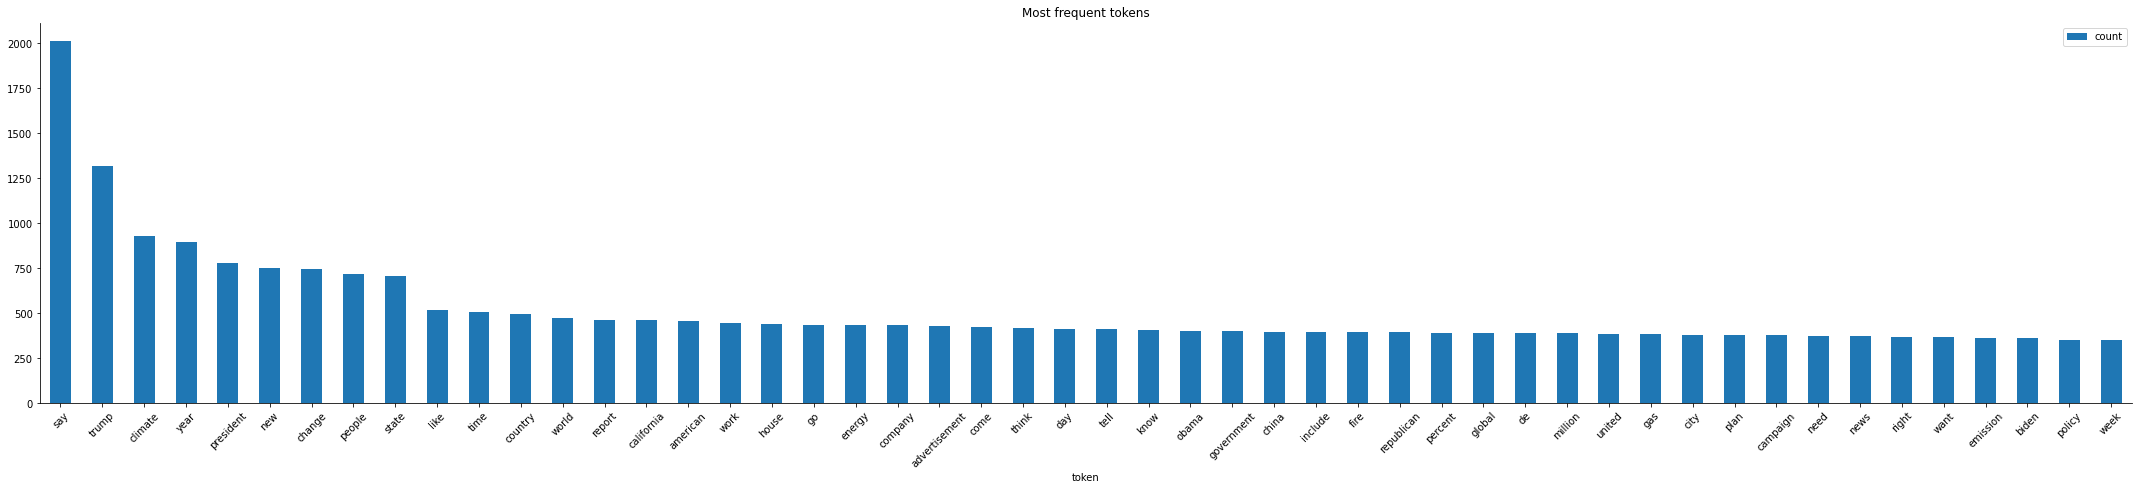

In [52]:
#helper function to print most common words from corpus

word_counts = X_train_transformed.toarray().sum(axis=0)
words = bagofwords.get_feature_names()

def plot_most_frequent(words, word_counts, top=50):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 7))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.savefig('tfidf_most_common_tokens.jpg')
    plt.show()
    
plot_most_frequent(words, word_counts)

In [45]:
#checking number of tokens
len(bagofwords.get_feature_names())

96005

In [55]:
#checking if covid in corpus
'covid' in bagofwords.get_feature_names()

True

In [61]:
#checking if coronavirus in corpus
bagofwords.vocabulary_['coronavirus']

20400